<br/>
<h1 style="font-family: 'Georgia', serif; text-align: center; font-size: 30px; color:rgb(52, 152, 219); text-shadow: 2px 2px 5px rgba(0, 0, 0, 0.3)">Modélisation
</h1>
<br/>

## Librairies et Données traitées

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df=pd.read_csv("data_treated")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31087 entries, 0 to 31086
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  31087 non-null  int64  
 1   person_age                  31087 non-null  int64  
 2   person_income               31087 non-null  float64
 3   person_home_ownership       31087 non-null  int64  
 4   person_emp_length           31087 non-null  float64
 5   loan_intent                 31087 non-null  int64  
 6   loan_grade                  31087 non-null  int64  
 7   loan_amnt                   31087 non-null  int64  
 8   loan_int_rate               31087 non-null  float64
 9   loan_status                 31087 non-null  int64  
 10  loan_percent_income         31087 non-null  float64
 11  cb_person_default_on_file   31087 non-null  int64  
 12  cb_person_cred_hist_length  31087 non-null  int64  
dtypes: float64(4), int64(9)
memory 

Nous allons construire un modèle capable de prédire si une personne sera en défaut de paiement ou non. Il s'agit donc d'un problème de classification. Nous allons tout d'abord scinder les données en données d'entrainement et données d'évaluation.

In [5]:
x = df.drop('loan_status',axis=1) #var explicative
y=df['loan_status'] #var d'interet

seed=123 # pour avoir le meme resultat à chaque execution
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=seed)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape) 

(21760, 12)
(9327, 12)
(21760,)
(9327,)


## Modèle de base avec l'algorithme RandomForestClassifier

In [6]:
#creation du modele
rf = RandomForestClassifier(random_state=seed)

#entrainnement du modele
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=123)

<br/>
<h1 style="font-family: 'Georgia', serif; text-align: left; font-size: 30px; color:rgb(226, 93, 31)">
<ul style="list-style-type: square;">
<li>
Evaluation des performances du Modèle
</li>
</ul> 
</h1>

Afin de choisir une métrique d'évaluation du modèle, nous allons tout d'abord calculer la précision du modèle

In [8]:
print("le score sur les données d'entrainement est  : ", rf.score(x_train,y_train))
print("le score sur les données d'évaluation est  : ", rf.score(x_test,y_test))

le score sur les données d'entrainement est  :  1.0
le score sur les données d'évaluation est  :  0.9351345555912941


ces Valeurs, très proches de 1, nous indique que environ 100% des statuts de prets ont été correctement prédits au niveau des données d'entrainement et 94% environ au niveau des données d'évaluation. cet écart indique qu'il y'a un problème de sur apprentissage(overfiting).
<p>Nous pouvons aussi évaluer le modèle grace à la fonction classification_report().<p>

In [9]:
#prediction des données sur le test data
y_pred= rf.predict(x_test)
#rapport de classification
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.97      0.72      0.83      2037

    accuracy                           0.94      9327
   macro avg       0.95      0.86      0.89      9327
weighted avg       0.94      0.94      0.93      9327




<h2>Rapport de classification :</h2>
<p>
Classe 0 (prêts sans défaut) :
<br/>
Précision (93%) : Parmi les prédictions de la classe 0, 93% sont correctes.
<br/>Recall (99%) : Parmi les vrais prêts sans défaut, 99% sont bien détectés.
<br/>F1-score (96%) : Bon équilibre entre précision et rappel.

</p>
<p>
<br/>Classe 1 (prêts avec défaut) :
<br/>
Précision (97%) : Parmi les prédictions de défauts, 97% sont correctes.
<br/>Recall (72%) : Parmi les vrais défauts, seulement 72% sont détectés.
<br/>F1-score (83%) : Acceptable mais montre une certaine faiblesse à détecter tous les défauts.
<br/>Accuracy (94%) : Globalement, 94% des prêts sont correctement classifiés.
<br/>
Macro avg (89% pour F1) : Indique un déséquilibre de performance entre les classes.
<br/>
Weighted avg (93% pour F1) : Pondère les classes selon leur support.
<br/>
</p>
<p>
Problème potentiel :
<br/>
Le modèle semble mieux prédire la classe 0 (prêts sans défaut) que la classe 1 (défauts de paiement). Cela peut être dû à un déséquilibre <br/>des classes, comme visible dans le support (7290 contre 2037).
</p>
<p>
Ce modèle est donc très risqué car bien qu'il a globalement une grande précision, seulement 72% des vrais défauts sont détectés. Ce qui signifie que pour 100 prets de 3000$ la perte d'argent serait estimée à 0,27*100*3000 = 810 000$ ce qui est énorme.
<br/> Nous avons donc un problème d'overfiting et un problème de mauvaise prédiction des prets en défauts de paiement
</p>

<br/>
<h1 style="font-family: 'Georgia', serif; text-align: left; font-size: 22px; color:rgb(226, 93, 31)">
<ul style="list-style-type: circle;">
<li>
Determination de l'importance des prédicteurs
</li>
</ul> 
</h1>

In [11]:
vars_imp= pd.Series(rf.feature_importances_, index= x.columns).sort_values(ascending= False)
vars_imp

loan_percent_income           0.209898
person_income                 0.143977
loan_grade                    0.114784
loan_int_rate                 0.092198
person_home_ownership         0.089136
Unnamed: 0                    0.081447
loan_intent                   0.070064
loan_amnt                     0.067316
person_emp_length             0.056073
person_age                    0.035834
cb_person_cred_hist_length    0.027771
cb_person_default_on_file     0.011502
dtype: float64

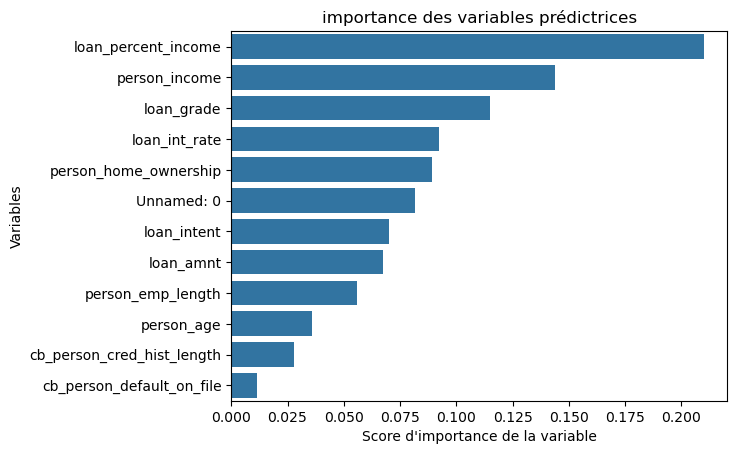

In [12]:
#visualisation des variables importantes
sns.barplot(x=vars_imp, y=vars_imp.index)
plt.xlabel("Score d'importance de la variable")
plt.ylabel('Variables')
plt.title("importance des variables prédictrices")
plt.show()

<br/>
<h1 style="font-family: 'Georgia', serif; text-align: left; font-size: 22px; color:rgb(226, 93, 31)">
<ul style="list-style-type: circle;">
<li>
(re)construction du modèle de Random Forrest
</li>
</ul> 
</h1>

Nous allons reconstruire le modèle avec les variables d'importance supérieure à 0,020

In [14]:
#VAr de score > 0,010
vars_selected = vars_imp[vars_imp > 0.020].index.to_list()
vars_selected

['loan_percent_income',
 'person_income',
 'loan_grade',
 'loan_int_rate',
 'person_home_ownership',
 'Unnamed: 0',
 'loan_intent',
 'loan_amnt',
 'person_emp_length',
 'person_age',
 'cb_person_cred_hist_length']

In [15]:

seed=123 # pour avoir le meme resultat à chaque execution
x_train, x_test, y_train, y_test = train_test_split(x[vars_selected], y, stratify=y, test_size=0.3, random_state=seed)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape) 

(21760, 11)
(9327, 11)
(21760,)
(9327,)


In [18]:
rf2 = RandomForestClassifier(random_state=seed)
rf2.fit(x_train, y_train)
#prediction des données sur le test data
y_pred2= rf2.predict(x_test)
#rapport de classification
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      7290
           1       0.97      0.73      0.83      2037

    accuracy                           0.94      9327
   macro avg       0.95      0.86      0.90      9327
weighted avg       0.94      0.94      0.93      9327



les performances du modèle n'ont pas été améliorées. Nous allons procéder au sous échantillonnage afin de former un ensemble de données équilibré.

<br/>
<h1 style="font-family: 'Georgia', serif; text-align: left; font-size: 22px; color:rgb(226, 93, 31)">
<ul style="list-style-type: circle;">
<li>
Méthode de sous-échantillonnage
</li>
</ul> 
</h1>

In [20]:
df_train = pd.concat([x_train.reset_index(drop=True),y_train.reset_index(drop=True)],axis=1)
#nombre de prets dans chaque classe
n_nonDefauts, n_defauts= df_train['loan_status'].value_counts()
defauts_df= df_train[df_train['loan_status']==1]
nonDefauts_df= df_train[df_train['loan_status']==0]
#sous echantillonnage des non defauts pour qu'ils soient au meme nombre que les defauts
nonDefauts_df2 = nonDefauts_df.sample(n_defauts)
#concaténation
df_train2= pd.concat([nonDefauts_df2.reset_index(drop=True), defauts_df.reset_index(drop=True)], axis=0)
#verification du nombre de prets de chaque classe
df_train2['loan_status'].value_counts()

loan_status
0    4752
1    4752
Name: count, dtype: int64

Nous allons construire un modèle de forets aléatoires sur ce nouvel ensemble de données

In [21]:
x = df_train2.drop('loan_status',axis=1) #var explicative
y=df_train2['loan_status'] #var d'interet

seed=123 # pour avoir le meme resultat à chaque execution
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=seed)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape) 

#creation du modèle

rf3 = RandomForestClassifier(random_state=seed)
#entrainnement du modele
rf3.fit(x_train,y_train)
#predictions
y_pred3= rf3.predict(x_test)

#rapport de classification
print(classification_report(y_test,y_pred3))


(6652, 11)
(2852, 11)
(6652,)
(2852,)
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1426
           1       0.91      0.77      0.83      1426

    accuracy                           0.84      2852
   macro avg       0.85      0.84      0.84      2852
weighted avg       0.85      0.84      0.84      2852



Ce nouveau modèle predit les défauts de paiement avec beaucoup plus de précision(77% des prets en défauts correctement prédits) que les modèles précédents

## Nous pouvons visualiser les règles de notre modèle

In [22]:
# Accéder au premier arbre de la forêt
tree = rf3.estimators_[0]

from sklearn.tree import export_text
# Obtenir l'arbre sous forme de règles
rules = export_text(tree, feature_names=list(x_train.columns))
print(rules)


|--- loan_percent_income <= 0.31
|   |--- person_home_ownership <= 0.50
|   |   |--- loan_percent_income <= 0.18
|   |   |   |--- person_income <= 10.59
|   |   |   |   |--- Unnamed: 0 <= 1472.50
|   |   |   |   |   |--- person_income <= 9.69
|   |   |   |   |   |   |--- loan_int_rate <= 10.93
|   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |--- loan_int_rate >  10.93
|   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- person_income >  9.69
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |--- Unnamed: 0 >  1472.50
|   |   |   |   |   |--- loan_grade <= 2.50
|   |   |   |   |   |   |--- loan_int_rate <= 12.09
|   |   |   |   |   |   |   |--- loan_intent <= 3.50
|   |   |   |   |   |   |   |   |--- loan_intent <= 2.50
|   |   |   |   |   |   |   |   |   |--- loan_amnt <= 5037.50
|   |   |   |   |   |   |   |   |   |   |--- person_age <= 27.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 10
|   |   |   |   |   |   

## visualisation graphique de des arbres

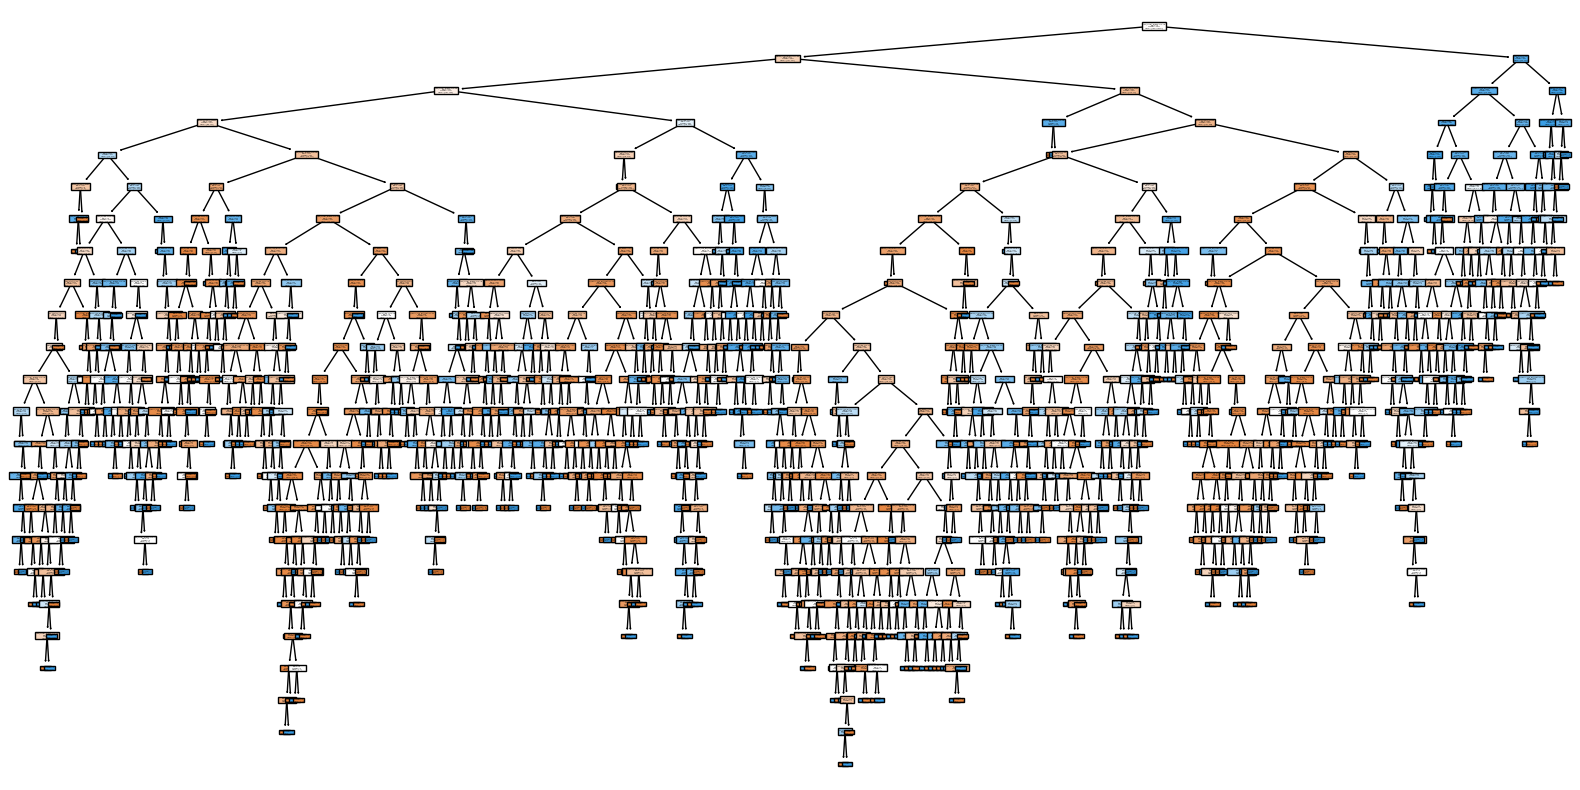

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualisation d'un arbre
plt.figure(figsize=(20, 10))
plot_tree(rf3.estimators_[0], filled=True, feature_names=x_train.columns)
plt.show()


## importance des variables dans ce modèle

In [23]:
# Importance des caractéristiques
importances = rf3.feature_importances_
for feature, importance in zip(x_train.columns, importances):
    print(f"{feature}: {importance:.4f}")


loan_percent_income: 0.1969
person_income: 0.1586
loan_grade: 0.1323
loan_int_rate: 0.1107
person_home_ownership: 0.0622
Unnamed: 0: 0.0814
loan_intent: 0.0615
loan_amnt: 0.0715
person_emp_length: 0.0511
person_age: 0.0412
cb_person_cred_hist_length: 0.0328


<br/>
<h1 style="font-family: 'Georgia', serif; text-align: left; font-size: 30px; color:rgb(226, 93, 31)">
<ul style="list-style-type: square;">
<li>
<u>
CONCLUSION
</u>
</li>
</ul> 
</h1>

<p>
Ce projet avait pour objectif de développer un modèle prédictif capable d’évaluer le risque de crédit des clients d’une institution financière. En utilisant diverses méthodes de machine learning, nous avons cherché à identifier les profils présentant un risque élevé de défaut de paiement.
</p>
<p>
Après une analyse exploratoire approfondie des données, incluant la gestion des valeurs manquantes et la sélection des variables explicatives pertinentes, un modèle de classification basé sur les forêts aléatoires (Random Forest) a été entraîné. Cette méthode a été privilégiée pour sa capacité à capturer des relations complexes entre les variables et à gérer les données bruitées.
</p>
<p>
Les résultats obtenus montrent une bonne performance globale du modèle, avec une précision élevée sur la classe majoritaire (clients sans défaut) et une détection correcte des cas de défaut. Toutefois, le score de rappel légèrement inférieur pour les clients en défaut révèle une marge d’amélioration possible pour mieux équilibrer la capacité du modèle à identifier ces cas critiques.